In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

Lets take some ideas from this paper:

https://arxiv.org/pdf/1906.00091


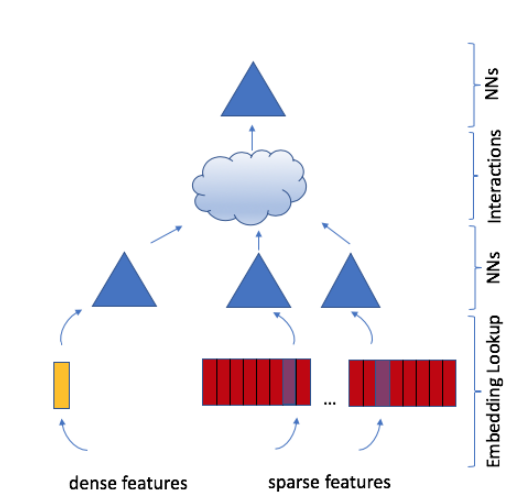

What is happening here?


### Embeddings:
Features are divided into two sets:

Dense and Sparse.

Dense features are those that contain something related to the user (Age, Gender, Location, Rating, ETC ETC)

Sparse features are those that contain data relating to the Search/Scan variables -- Movies/Books, items being rated.

So, next we shall create embedding tables for the one-hot encoded sparse data. How many dimensions to keep? Lets decide it on our own later.

So weight of the ith feature of the sparse matrix from the embedding W ($m*d$) can thus be derived as:

$w_{i}=e^{T}_{i}W$

and taking a batch of size A: Sample S of users is derived as:

$S=A^{T}W$

### Matrix Factorization:

Let $r_{i,j}$ be the rating of the ith product by the jth user. Let V be the user embedding table with n users, shape: $n*d$

So, R, the full ratings table can be approximated as : $R=W^{T}V$

of shape $(m*d) @ (n*d)^{T} -> (m,d)*(d, n) -> (m,n)$

and consequently, beginning with some R, we can achieve this by iteratively minimizing:

$\sum{r_{i,j} - w^{T}_{i}v_{j}}$ 

But, a lot of users will rate very few movies and a lot of movies will have very few ratings.

Thus, we shall add some L2 regularization:

$\sum{r_{i,j} - w^{T}_{i}v_{j}} + \sum{||{w_{i}}||^{2}} + \sum{||{v_{j}}||^{2}}$ 

Which is our loss function




### Factorization Machine:
**Essentially a dot product to find out some sort of co-variance between the user and movie embed outputs**

Let the target labels y be +1 or -1 indicating the presence or absence of a click.

Let x be an n dim input label as well. 

Lets define

$y = b + w^{T}x + x^{T}upper(V*V^{T})x$

upper is essential torch.triu (brother of torch.tril)

Lets look at the dimensions

b: Scalar; w: W(m,d) - > d; x -> n (all users I suppose broes); VVT -> (n,d)*(d,n) -> (n,n) 

### Full Architecture:

Let the users and products be described by many continuous and categorical features. To process
the categorical features, each categorical feature will be represented by an embedding vector of the
same dimension, generalizing the concept of latent factors used in matrix factorization (3). To handle
the continuous features, the continuous features will be transformed by an MLP (which we call the
bottom or dense MLP) which will yield a dense representation of the same length as the embedding
vectors.

We will compute second-order interaction of different features explicitly, following the intuition for
handling sparse data provided in FMs (4), optionally passing them through MLPs. This is done by
taking the dot product between all pairs of embedding vectors and processed dense features. These
dot products are concatenated with the original processed dense features and post-processed with
another MLP (the top or output MLP) (5), and fed into a sigmoid function to give a probability.

### Create Data Batches

In [3]:
df = pd.read_csv("ratings_small.csv", usecols = ['userId','movieId','rating'])
df

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


In [4]:
# Create a dictionary to map userId and movieId to indices
user_dict = {user: i for i, user in enumerate(df['userId'].unique())}
movie_dict = {movie: i for i, movie in enumerate(df['movieId'].unique())}

# Convert userId and movieId to indices
df['userId'] = df['userId'].map(user_dict)
df['movieId'] = df['movieId'].map(movie_dict)

num_users = len(df.userId.unique())
num_movies = len(df.movieId.unique())

print("Shape of Dense/User Embed:", num_users)
print("Shape of Sparse/Movie Embed:", num_movies)

Shape of Dense/User Embed: 671
Shape of Sparse/Movie Embed: 9066


In [5]:
device = torch.device('cuda')

In [6]:
train_data, test_data = train_test_split(df, test_size=0.2)

class CustomData(Dataset):

    def __init__(self, df):
        self.df = df.values
        self.device = torch.device('cuda')
    
    def __getitem__(self, idx):
        user = torch.tensor(self.df[idx, 0], dtype=torch.int32).to(self.device)
        movie = torch.tensor(self.df[idx, 1], dtype=torch.int32).to(self.device)
        target = torch.tensor(self.df[idx, 2], dtype=torch.float32).to(self.device)

        return user, movie, target

    def __len__(self):
        return len(self.df)

train_dataset = CustomData(train_data)
test_dataset = CustomData(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

### Simple Matrix Factorization Model:

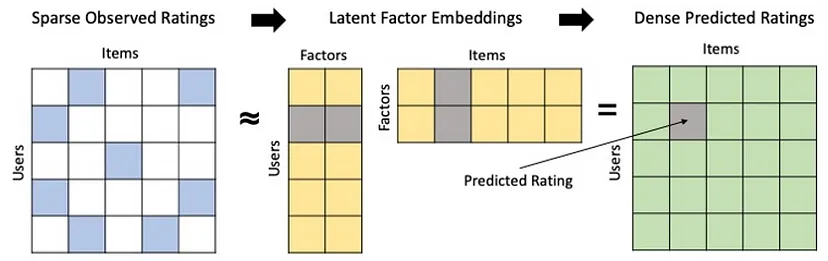

In [5]:
# lets begin with a simple matrix factorization with no MLPs:

class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items):
        super(MF, self).__init__()
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(dim=1) + torch.squeeze(b_u) + torch.squeeze(b_i)
        return outputs.flatten()

In [346]:
@torch.no_grad()
def make_predictions(model, test_loader, device):
    model.eval()
    total_loss = 0
    metrics = 0
    loss = nn.MSELoss()
    for values in test_loader:
        # Load the batch
        users = values[0].to(device)
        movies = values[1].to(device)
        ratings = values[2].to(device)
        preds = model(users, movies)
        loss_val = loss(preds, ratings)
        total_loss += loss_val.item()
        metrics += 1
    return total_loss/metrics

In [347]:
device = torch.device('cuda')
mf = MF(16, num_users, num_movies).to(device)
optimizer = optim.Adam(mf.parameters(), lr=1e-4, weight_decay=0.0)
loss = nn.MSELoss()
num_epochs = 1000
train_losses = []
test_losses = []

In [349]:
optimizer = optim.Adam(mf.parameters(), lr=1e-3, weight_decay=0.0)


In [ ]:
for epoch in range(num_epochs):
    metric, total_loss = 0, 0
    print(f'Epoch {epoch+1}')
    for i, values in enumerate(train_loader):

        # Load the batch
        users = values[0].to(device)
        movies = values[1].to(device)
        ratings = values[2].to(device)

        preds = mf(users, movies)
        

        optimizer.zero_grad()
        loss_val = loss(preds, ratings)
        loss_val.backward()
        optimizer.step()
        total_loss += loss_val.item()
        metric += 1

        if i %500==0:
            print(f'-- -- -- {i} batches complete')
        
    train_loss = total_loss / metric
    train_losses.append(train_loss)

    test_loss = make_predictions(mf, test_loader, device)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1} Finished:: Train Loss: {train_loss:.2f} Validation_Loss: {test_loss:.2f}')
    print("###############################################")

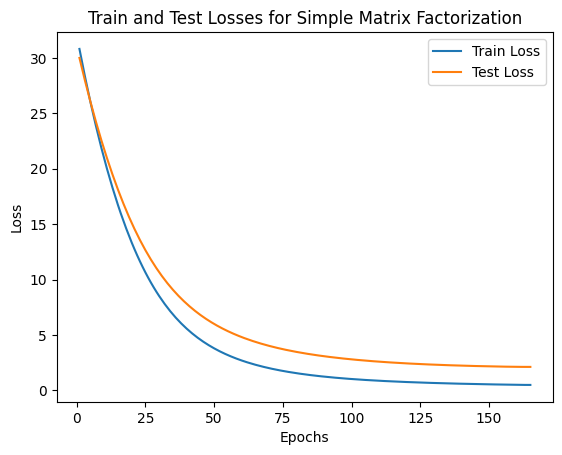

In [364]:

epochs = range(1, len(train_losses) + 1)

# Create the plot
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')

plt.title('Train and Test Losses for Simple Matrix Factorization')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [7]:
## MSE Final Valid: 2.12
## MSE Final Train: 0.51

### Neural Matrix Factorization

Same as MF, except we add some MLPs parallely

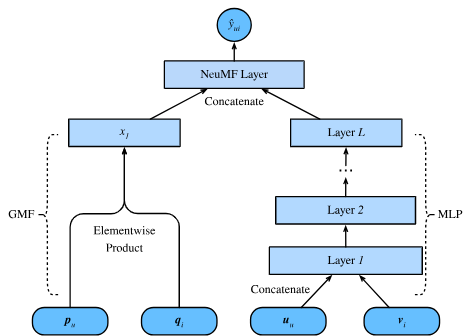

In [61]:
@torch.no_grad()
def make_predictions(model, test_loader):
    model.eval()
    total_loss = 0
    metrics = 0
    loss = nn.MSELoss()
    for values in test_loader:
        # Load the batch
        users, movies, ratings = values
        preds = model(users, movies)
        loss_val = loss(preds, ratings)
        total_loss += loss_val.item()
        metrics += 1
    return total_loss/metrics

In [71]:
class NeuralMF(nn.Module):
    def __init__(self, num_factors, num_users, num_items):
        super(NeuralMF, self).__init__()

        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        
        self.U = nn.Embedding(num_users, num_factors)
        self.V = nn.Embedding(num_items, num_factors)
        
        self.mlp =nn.Sequential(
            nn.Linear(num_factors*2, num_factors*4),
            nn.Linear(num_factors*4, num_factors),
            nn.ReLU())
        
        self.mlp_top =nn.Sequential(
            nn.Linear(num_factors*2, num_factors),
            nn.Linear(num_factors, 1),
            nn.ReLU())

    def forward(self, user_id, item_id):

        # Matrix Factorization Embeddings
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        # DotProduct
        gmf = p_mf * q_mf

        # MLP Embeds
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        
        # Concatenation + MLP
        mlp = self.mlp(torch.cat([p_mlp, q_mlp], dim=1))

        # Final Linear Layer
        con_res = torch.cat([gmf, mlp], dim=1)
        out = self.mlp_top(con_res).view(-1)

        return out
        

In [72]:
enumf = NeuralMF(16, num_users, num_movies).to(device)
device = torch.device('cuda')
optimizer = optim.Adam(enumf.parameters(), lr=1e-4, weight_decay=0.0)
loss = nn.MSELoss()
num_epochs = 1000
train_losses = []
test_losses = []

In [ ]:
for epoch in range(num_epochs):
    metric, total_loss = 0, 0
    print(f'Epoch {epoch+1}')
    for i, values in enumerate(train_loader):

        # Load the batch
        users, movies, ratings = values

        preds = enumf(users, movies)
        
        optimizer.zero_grad()
        loss_val = loss(preds, ratings)
        loss_val.backward()
        optimizer.step()
        total_loss += loss_val.item()
        metric += 1

        if i %500==0:
            print(f'-- -- -- {i} batches complete')
        
    train_loss = total_loss / metric
    train_losses.append(train_loss)

    test_loss = make_predictions(enumf, test_loader)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1} Finished:: Train Loss: {train_loss:.2f} Validation_Loss: {test_loss:.2f}')
    print("###############################################")

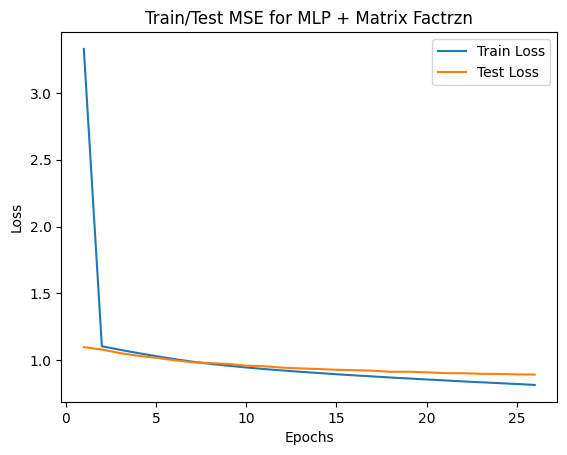

In [84]:
epochs = range(1, len(train_losses[:-1]) + 1)

# Create the plot
plt.plot(epochs, train_losses[:-1], label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')

plt.title('Train/Test MSE for MLP + Matrix Factrzn')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

Epoch 26 Finished:: Train Loss: 0.81 Validation_Loss: 0.89 (MSE)

This is much better than the loss of 2.12 from the simple MF architecture

#### How to get Recommendations from this model?

To make recommendations: select a user and then for that space select all movieIds.

This will give you a matrix of (num_movies, 2) where the first dimension is uniformly populated by the userId.

Finally, you will get the ratings for all movies -- which you can use to make preds

In [124]:
# Select a random userId
movieIds = torch.arange(9066, dtype=torch.int32).to(device)
userId = torch.randint(low = 0, high = 670, size= (1, )).item()
print("Making Preds for UserID:", userId)
userId = (torch.ones(num_movies, dtype=torch.int32)*userId).to(device)

print("User ID:", userId.shape, "Movie ID:", movieIds.shape)


enumf.eval()
test_loss = 0
with torch.no_grad():

    preds = enumf(userId, movieIds)


next_10_preds = preds.argsort()[-20:-10]

print("-------")
print("Making 10 Recommendations:")
for i in next_10_preds:
    print(f"-- -- MovieId: {movieIds[i]} with predicted User Rating of {preds[i]:.2f}")

Making Preds for UserID: 337
User ID: torch.Size([9066]) Movie ID: torch.Size([9066])
-------
Making 10 Recommendations:
-- -- MovieId: 24 with predicted User Rating of 4.55
-- -- MovieId: 1592 with predicted User Rating of 4.55
-- -- MovieId: 698 with predicted User Rating of 4.55
-- -- MovieId: 2697 with predicted User Rating of 4.56
-- -- MovieId: 158 with predicted User Rating of 4.56
-- -- MovieId: 7013 with predicted User Rating of 4.56
-- -- MovieId: 4775 with predicted User Rating of 4.58
-- -- MovieId: 938 with predicted User Rating of 4.60
-- -- MovieId: 6515 with predicted User Rating of 4.62
-- -- MovieId: 6448 with predicted User Rating of 4.62


### Factorization Machines:

Instead of attempting to approximate the sparse User-Item matrix as product of User X D and Item X D (latent features) -- we can use a single matrix of the dimensions (User + Item) X D.

This will reduce computations by a significant order and also ensure independence of all features.

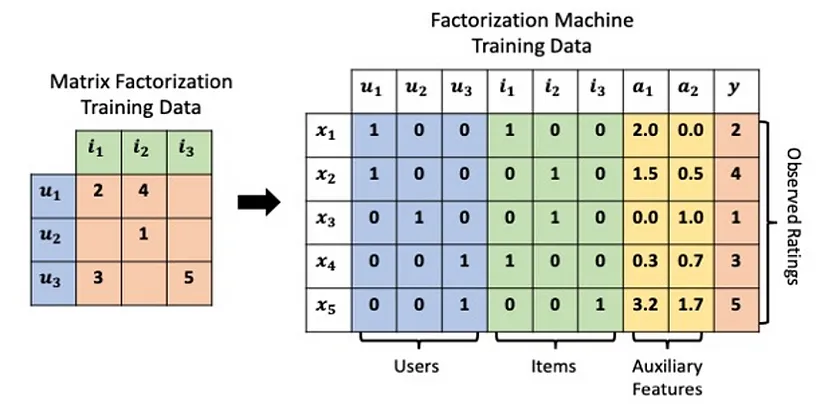

We fetch interactions by taking dot products over all items


$$
\hat{y}(x) = \mathbf{w}_0 + \sum_{i=1}^d \mathbf{w}_i x_i + \sum_{i=1}^d\sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j
$$

From an efficiency point of view: we can compute the interactions like this:


$$
\begin{aligned}
&\sum_{i=1}^d \sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j \\
 &= \frac{1}{2} \sum_{i=1}^d \sum_{j=1}^d\langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j - \frac{1}{2}\sum_{i=1}^d \langle\mathbf{v}_i, \mathbf{v}_i\rangle x_i x_i \\
 &= \frac{1}{2} \big (\sum_{i=1}^d \sum_{j=1}^d \sum_{l=1}^k\mathbf{v}_{i, l} \mathbf{v}_{j, l} x_i x_j - \sum_{i=1}^d \sum_{l=1}^k \mathbf{v}_{i, l} \mathbf{v}_{i, l} x_i x_i \big)\\
 &=  \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i) (\sum_{j=1}^d \mathbf{v}_{j, l}x_j) - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2 \big ) \\
 &= \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i)^2 - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2)
 \end{aligned}
$$


In [7]:
@torch.no_grad()
def make_predictions(model, test_loader):
    model.eval()
    total_loss = 0
    metrics = 0
    loss = nn.MSELoss()
    for values in test_loader:
        # Load the batch
        users, movies, ratings = values
        movies = movies + num_users
        x = torch.cat([users.view(-1, 1), movies.view(-1,1)], dim = 1)
        preds = model(x)

        loss_val = loss(preds, ratings)
        total_loss += loss_val.item()
        metrics += 1
    return total_loss/metrics

In [8]:
class FM(nn.Module):
    def __init__(self, field_dims, num_factors):
        super(FM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Linear(1, 1, bias=True)
        self.output_act = nn.ReLU()

    def forward(self, x):
        square_of_sum = torch.sum(self.embedding(x), dim=1) ** 2
        sum_of_square = torch.sum(self.embedding(x) ** 2, dim=1)

        diff_squares = 0.5 * (square_of_sum - sum_of_square).sum(1, keepdim=True)

        x = self.linear_layer(self.fc(x).sum(1)) + diff_squares
        x = self.output_act(x).view(-1)
        
        return x

df.userId.min(), num_users, df.userId.max(), df.movieId.min(), num_movies, df.movieId.max()

(0, 671, 670, 0, 9066, 9065)

Observe that the minimum movieId is also 0 -- this is not acceptable:

movieIds must begin from num_users + df.movieId.min() 

and must end at num_users + df.movieId.max()

make_transformation: movieID = movieID + num_users

In [9]:
device = torch.device('cuda')
fm = FM([num_users, num_movies], 16).to(device)
print(fm)
optimizer = optim.Adam(fm.parameters(), lr=1e-4, weight_decay=0.0)
loss = nn.MSELoss()
num_epochs = 1000
train_losses = []
test_losses = []

FM(
  (embedding): Embedding(9737, 16)
  (fc): Embedding(9737, 1)
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
  (output_act): ReLU()
)


In [13]:
optimizer = optim.Adam(fm.parameters(), lr=1e-4, weight_decay=0.0)

In [ ]:
for epoch in range(num_epochs):
    metric, total_loss = 0, 0
    print(f'Epoch {epoch+1}')
    for i, values in enumerate(train_loader):

        # Load the batch
        users, movies, ratings = values
        movies = movies + num_users
        x = torch.cat([users.view(-1, 1), movies.view(-1,1)], dim = 1)

        preds = fm(x)
        
        optimizer.zero_grad()
        loss_val = loss(preds, ratings)
        loss_val.backward()
        optimizer.step()
        total_loss += loss_val.item()
        metric += 1

        if i %500==0:
            print(f'-- -- -- {i} batches complete')
        
    train_loss = total_loss / metric
    train_losses.append(train_loss)

    test_loss = make_predictions(fm, test_loader)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1} Finished:: Train Loss: {train_loss:.2f} Validation_Loss: {test_loss:.2f}')
    print("###############################################")

Outputs:

Epoch 42:: Train Loss: 0.41 Validation_Loss: 1.65

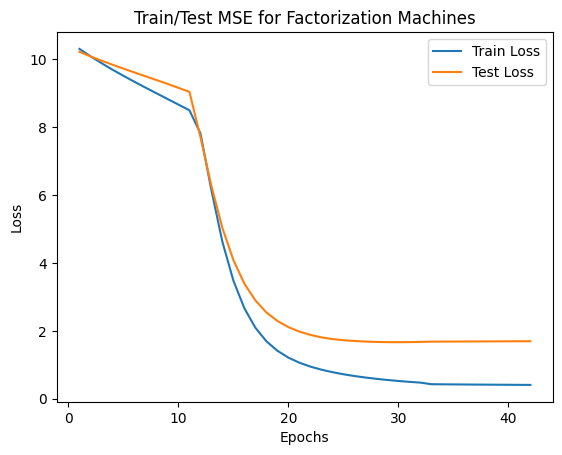

In [18]:
epochs = range(1, len(train_losses) + 1)

# Create the plot
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')

plt.title('Train/Test MSE for Factorization Machines')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

### MLP + Factorization Machines: 

Get an output from an MLP and also get one from FM:

Finally, add them together and pass them through an output layer.

Since we are regressing, we will use a ReLU layer, otherwise a sigmoid layer would work.

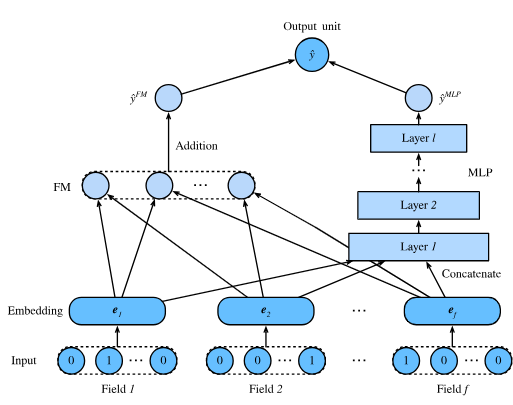

In [31]:
@torch.no_grad()
def make_predictions(model, test_loader):
    model.eval()
    total_loss = 0
    metrics = 0
    loss = nn.MSELoss()
    for values in test_loader:
        # Load the batch
        users, movies, ratings = values
        movies = movies + num_users
        x = torch.cat([users.view(-1, 1), movies.view(-1,1)], dim = 1)
        preds = model(x)

        loss_val = loss(preds, ratings)
        total_loss += loss_val.item()
        metrics += 1
    return total_loss/metrics

In [44]:
class DeepFM(nn.Module):
    def __init__(self, field_dims, num_factors, drop_rate=0.1):
        super(DeepFM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Linear(1, 1)

        input_dim = self.embed_output_dim = len(field_dims) * num_factors
        self.mlp =nn.Sequential(
            nn.Linear(num_factors*2, num_factors*4),
            nn.Linear(num_factors*4, num_factors),
            nn.Dropout(drop_rate),
            nn.ReLU())
        
        self.mlp_top =nn.Sequential(
            nn.Linear(num_factors, 1),
            nn.ReLU())

    def forward(self, x):
        # Same stuff as factorization machine: 
        embed_x = self.embedding(x)
        square_of_sum = torch.sum(embed_x, dim=1) ** 2
        sum_of_square = torch.sum(embed_x ** 2, dim=1)
        inputs = torch.reshape(embed_x, (-1, self.embed_output_dim))
        diffs = 0.5 * (square_of_sum - sum_of_square).sum(1, keepdim=True)

        x = self.linear_layer(self.fc(x).sum(1)) + self.mlp(inputs) + diffs
        x = self.mlp_top(x).view(-1)
        return x

In [45]:
device = torch.device('cuda')
deepfm = DeepFM([num_users, num_movies], 16).to(device)
print(deepfm)
optimizer = optim.Adam(deepfm.parameters(), lr=1e-3, weight_decay=0.0)
loss = nn.MSELoss()
num_epochs = 1000
train_losses = []
test_losses = []

DeepFM(
  (embedding): Embedding(9737, 16)
  (fc): Embedding(9737, 1)
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=16, bias=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
  )
  (mlp_top): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [48]:
optimizer = optim.Adam(deepfm.parameters(), lr=1e-4, weight_decay=0.0)


In [ ]:
for epoch in range(num_epochs):
    metric, total_loss = 0, 0
    print(f'Epoch {epoch+1}')
    for i, values in enumerate(train_loader):

        # Load the batch
        users, movies, ratings = values
        movies = movies + num_users
        x = torch.cat([users.view(-1, 1), movies.view(-1,1)], dim = 1)

        preds = deepfm(x)
        
        optimizer.zero_grad()
        loss_val = loss(preds, ratings)
        loss_val.backward()
        optimizer.step()
        total_loss += loss_val.item()
        metric += 1

        if i %500==0:
            print(f'-- -- -- {i} batches complete')
        
    train_loss = total_loss / metric
    train_losses.append(train_loss)

    test_loss = make_predictions(deepfm, test_loader)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1} Finished:: Train Loss: {train_loss:.2f} Validation_Loss: {test_loss:.2f}')
    print("###############################################")

Finally, Train Loss: 0.61 Validation_Loss: 0.81


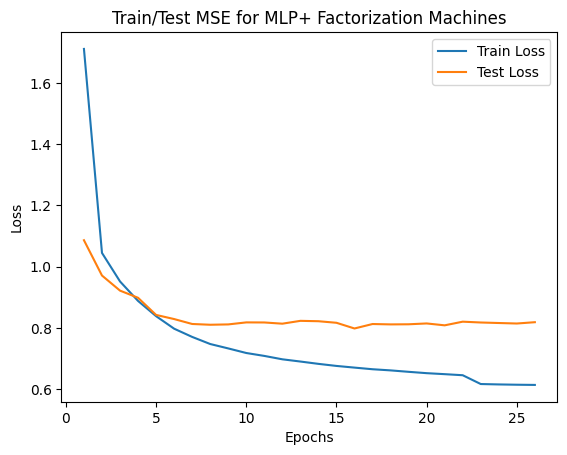

In [52]:
epochs = range(1, len(train_losses) )

# Create the plot
plt.plot(epochs, train_losses[:-1], label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')

plt.title('Train/Test MSE for MLP+ Factorization Machines')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

### Comments:

We started out with a simple matrix factorization and ended up with:

MSE Final Valid: 2.12
MSE Final Train: 0.51

Then we added MLPs on top of it and were able to achieve
Train Loss: 0.81 Validation_Loss: 0.89 in just 25 Epochs as opposed to a 100 to achieve the former.

Then we switched to Factorization Machines: they were more compute cheap and were capable of converged faster.

In our simple Factorization Machine, we hit 

Epoch 42:: Train Loss: 0.41 Validation_Loss: 1.65

When we added MLPs on top it:

We achieved: 

Train Loss: 0.61 Validation_Loss: 0.81

Factorization Matrix with MLP works the best and is easily generalizable to more features as well.